In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.7 MB/s eta 0:00:0000:0100:01


In [5]:
import wandb

In [6]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [10]:
import os

path = '/kaggle/input'
print(os.listdir(path))


['public_data_test']


In [11]:
train_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/train/ptbr.csv")
train_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/train/ptbr.csv")


dev_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/dev/ptbr.csv")
dev_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/dev/ptbr.csv")


test_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/test/ptbr.csv")
test_ptbr = pd.read_csv("/kaggle/input/public_data_test/track_b/test/ptbr.csv")

# BRAZILIAN PORTUGUESE

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [12]:
train_ptbr.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ptbr_train_track_b_00001,Moça eu fiz uma análise com o Tinder uma vez e...,0,0,0,0,0,0
1,ptbr_train_track_b_00002,"eles sempre mostram a míseria, em como tudo er...",1,2,0,0,0,0
2,ptbr_train_track_b_00003,eu nunca quis tanto algo como quero você. jama...,0,0,0,1,1,0
3,ptbr_train_track_b_00004,esperando aqui o stf vim me emparedar do eu ex...,1,0,0,0,0,0
4,ptbr_train_track_b_00005,"e no final o PS vai pagar o pato, ja é o 4° tr...",1,0,0,0,0,0


In [13]:
train_ptbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2226 non-null   object
 1   text      2226 non-null   object
 2   anger     2226 non-null   int64 
 3   disgust   2226 non-null   int64 
 4   fear      2226 non-null   int64 
 5   joy       2226 non-null   int64 
 6   sadness   2226 non-null   int64 
 7   surprise  2226 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 139.2+ KB


In [14]:
dev_ptbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        200 non-null    object
 1   text      200 non-null    object
 2   anger     200 non-null    int64 
 3   disgust   200 non-null    int64 
 4   fear      200 non-null    int64 
 5   joy       200 non-null    int64 
 6   sadness   200 non-null    int64 
 7   surprise  200 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 12.6+ KB


<Axes: >

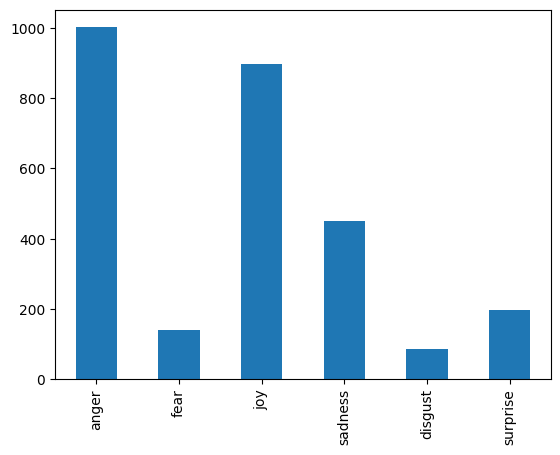

In [15]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust','surprise']
train_ptbr[attributes].sum().plot.bar()

<Axes: >

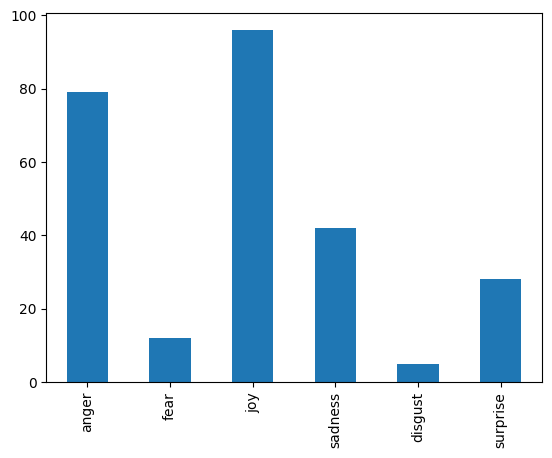

In [ ]:
dev_ptbr[attributes].sum().plot.bar()

In [17]:
test_ptbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2226 non-null   object 
 1   text      2226 non-null   object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 139.2+ KB


In [18]:
test_ptbr.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ptbr_test_track_b_00001,me recuso a sair de casa nesse frio do caralho...,NaN,NaN,NaN,NaN,NaN,NaN
1,ptbr_test_track_b_00002,tenho desde camisola nova até vestido de festa...,NaN,NaN,NaN,NaN,NaN,NaN
2,ptbr_test_track_b_00003,"minha playlist de descobertas veio com trap, r...",NaN,NaN,NaN,NaN,NaN,NaN
3,ptbr_test_track_b_00004,"Então, acho que ele gosta de homem e nem sabe ...",NaN,NaN,NaN,NaN,NaN,NaN
4,ptbr_test_track_b_00005,"Parabéns, Prof. Fernando. Parabéns às educador...",NaN,NaN,NaN,NaN,NaN,NaN


https://huggingface.co/FacebookAI/xlm-roberta-base

In [19]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness","surprise"]

In [49]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none"  
)


In [50]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,185,030 || all params: 279,233,292 || trainable%: 0.4244
None


In [ ]:
def tokenize_with_emotions(batch):
    emotions = "anger, disgust, fear, joy, sadness, or surprise?" 
    return tokenizer(emotions, batch['text'], padding=True, truncation=True, max_length=128)


In [ ]:
def encode_data_with_demux(df, tokenizer):
    emotions = ["anger", "disgust", "fear", "joy", "sadness","surprise"]
    text_with_emotions = [", ".join(emotions) + "?" + " " + t for t in df['text']]
    encodings = tokenizer(text_with_emotions, truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness',"surprise"]].fillna(0).values
    return encodings, labels

In [65]:
train_encodings, train_labels = encode_data_with_demux(train_ptbr, tokenizer)
dev_encodings, dev_labels = encode_data_with_demux(dev_ptbr, tokenizer)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [67]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [ ]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

train_lengths = calculate_token_lengths(train_ptbr['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_ptbr['text'], tokenizer)
test_lengths = calculate_token_lengths(test_ptbr['text'], tokenizer)

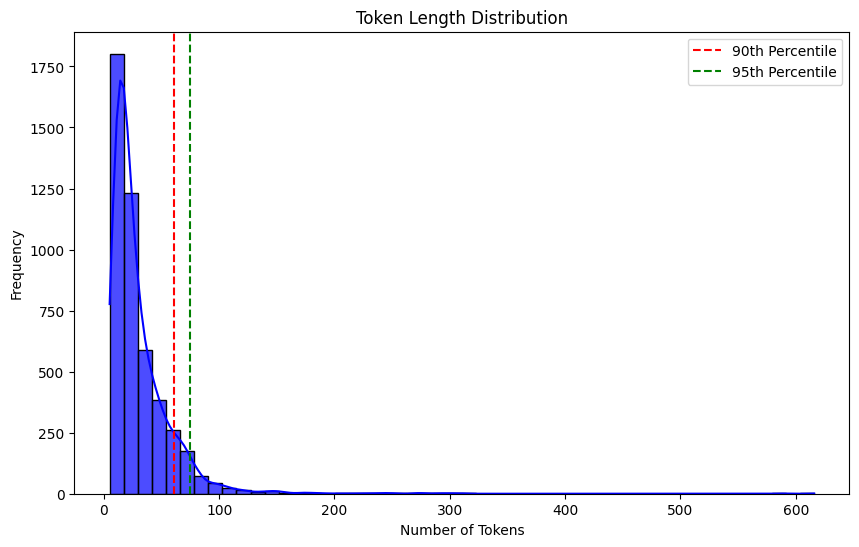

In [ ]:
all_lengths = train_lengths + dev_lengths + test_lengths

plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [70]:
from transformers import EarlyStoppingCallback

In [ ]:
from scipy.stats import pearsonr

def compute_pearson_corr(predictions, labels):
    """
    Compute Pearson Correlation between predictions and labels.
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    corr, _ = pearsonr(predictions.flatten(), labels.flatten())
    return corr


In [ ]:
import torch
import torch.nn as nn

class custom_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, labels):
        return self.mse_loss(outputs, labels)

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = custom_loss()

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        """
        Custom loss function for the Hugging Face Trainer.
        """
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Extract logits

        loss = self.loss_fn(logits, labels) 

        return (loss, outputs) if return_outputs else loss


In [ ]:

from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(p: EvalPrediction):
    """
    Compute metrics for evaluation, including Pearson Correlation, Accuracy, Precision, Recall, and F1 score.
    """
    predictions, labels = p.predictions, p.label_ids
    
    predictions_rounded = np.round(predictions).astype(int)
    
    labels_flattened = labels.flatten()
    predictions_flattened = predictions_rounded.flatten()
    
    pearson_corr = compute_pearson_corr(predictions, labels)
    overall_accuracy = accuracy_score(labels_flattened, predictions_flattened)
    precision = precision_score(labels_flattened, predictions_flattened, average='macro')
    recall = recall_score(labels_flattened, predictions_flattened, average='macro')
    f1 = f1_score(labels_flattened, predictions_flattened, average='macro')
    
    return {
        "pearson_corr": pearson_corr,
        "overall_accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/ptbr/xlm-roberta-base-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [77]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  
    early_stopping_threshold=0.01  
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [79]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [80]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.276600,0.284724,0.315927,0.839167,0.280156,0.265731,0.259948
1000,0.239400,0.230344,0.521520,0.835833,0.498173,0.367535,0.350325
1500,0.224500,0.218533,0.557244,0.835000,0.457704,0.390038,0.387317
2000,0.206300,0.215265,0.566613,0.842500,0.471520,0.396177,0.405384
2500,0.206400,0.212257,0.584490,0.840833,0.458473,0.413010,0.415657
3000,0.195700,0.209002,0.594089,0.847500,0.464995,0.412373,0.420840
3500,0.196100,0.205770,0.602085,0.850000,0.467342,0.413110,0.422719


In [ ]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [ ]:
import numpy as np

predictions, labels, _ = trainer.predict(dev_dataset)  

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)


Discrete predictions (0-3): [[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [1 0 0 0 0 0]]


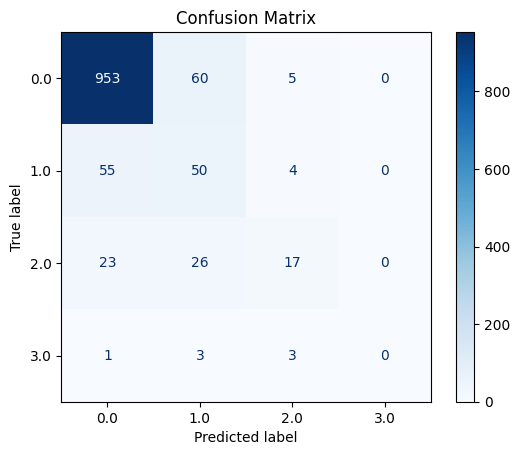

In [ ]:
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [85]:
pre=np.round(predictions).astype(int)

In [84]:

predictions = np.array(pre)
labels = np.array(labels)


if predictions.ndim > 1 and labels.ndim > 1:
    accuracies = []
    for i in range(predictions.shape[1]):  
        acc = accuracy_score(labels[:, i], predictions[:, i])
        accuracies.append(acc)
    overall_accuracy = np.mean(accuracies)
else:
    overall_accuracy = accuracy_score(labels, predictions)

print(f"Accuracy: {overall_accuracy:.2f}")

Accuracy: 0.86


In [ ]:
test_encodings = tokenizer(list(test_ptbr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ptbr), 6))) 
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [ ]:
test_ptbr[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ptbr.to_csv('test_predictions_ptbr_xlm_roberta_v2.csv', index=False)